## NEWW

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap


In [ ]:
def process_pupillometry_data(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)

    # Assuming 'data' is a dictionary and the NumPy array is stored under the key 'pupil_data'
    pupil_data = data['data']  # Access the NumPy array within the dictionary

    print("Keys in the pickle file:", data.keys())

    condition_labels = [
        'justlisten/five', 'memory/correct/five', 'memory/incorrect/five',
        'justlisten/nine', 'memory/correct/nine', 'memory/incorrect/nine',
        'justlisten/thirteen', 'memory/correct/thirteen', 'memory/incorrect/thirteen'
    ]

    subjects, conditions, epochs, time_points, channels, eyes = pupil_data.shape

    # Reshape data for classification
    reshaped_data = pupil_data.reshape(subjects * conditions * epochs, time_points * channels * eyes)

    # Binary Classification Labels (Just Listen vs. Memory)
    binary_labels = []
    for i in range(subjects):
        for j, condition in enumerate(condition_labels):
            for k in range(epochs):
                if 'justlisten' in condition:
                    binary_labels.append(0)  # Just Listen
                else:
                    binary_labels.append(1)  # Memory (Cognitively Engaged)

    binary_labels = np.array(binary_labels)

    # Cognitive Load Labels (0, Low, Medium, High)
    cognitive_load_labels = []
    for i in range(subjects):
        for j, condition in enumerate(condition_labels):
            for k in range(epochs):
                if 'justlisten' in condition:
                    cognitive_load_labels.append(0)  # 0 (Just Listen)
                elif 'five' in condition:
                    cognitive_load_labels.append(1)  # Low (5)
                elif 'nine' in condition:
                    cognitive_load_labels.append(2)  # Medium (9)
                elif 'thirteen' in condition:
                    cognitive_load_labels.append(3)  # High (13)

    cognitive_load_labels = np.array(cognitive_load_labels)

    return reshaped_data, binary_labels, cognitive_load_labels

In [ ]:
# Assume 'your_data.pkl' is the path to your pickle file
pickle_file_path = '/content/drive/MyDrive/Thesis/compiled_pupil_6D_array.pkl'
reshaped_data, binary_labels, cognitive_load_labels = process_pupillometry_data(pickle_file_path)

# Split data for binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    reshaped_data, binary_labels, test_size=0.2, random_state=42, stratify=binary_labels
)

# Split data for multiclass classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    reshaped_data, cognitive_load_labels, test_size=0.2, random_state=42, stratify=cognitive_load_labels
)

print("Shape of reshaped data:", reshaped_data.shape)
print("Shape of binary labels:", binary_labels.shape)
print("Shape of cognitive load labels:", cognitive_load_labels.shape)

Keys in the pickle file: dict_keys(['data', 'subjects', 'conditions', 'eyes', 'srate'])
Shape of reshaped data: (31680, 6962)
Shape of binary labels: (31680,)
Shape of cognitive load labels: (31680,)


In [ ]:
# --- Function to plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



--- Random Forest ---
Binary Training Time: 969.86 seconds
Binary Prediction Time: 1.09 seconds
Binary Classification Accuracy: 0.4635416666666667
Binary Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.58      0.70      0.63      4224

    accuracy                           0.46      6336
   macro avg       0.29      0.35      0.32      6336
weighted avg       0.39      0.46      0.42      6336



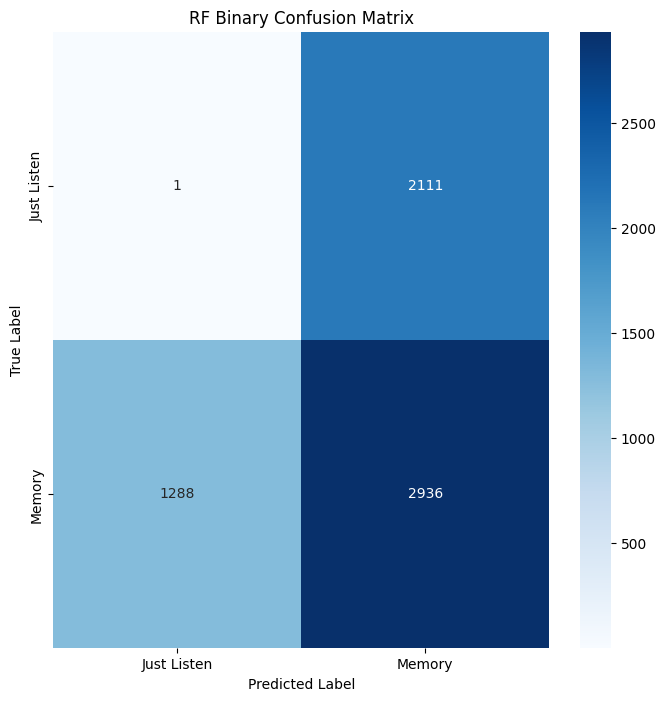

Multiclass Training Time: 672.44 seconds
Multiclass Prediction Time: 0.55 seconds
Multiclass Classification Accuracy: 0.4228219696969697
Multiclass Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.11      0.11      2112
           1       0.58      0.63      0.60      1408
           2       0.56      0.56      0.56      1408
           3       0.56      0.55      0.55      1408

    accuracy                           0.42      6336
   macro avg       0.45      0.46      0.46      6336
weighted avg       0.41      0.42      0.42      6336



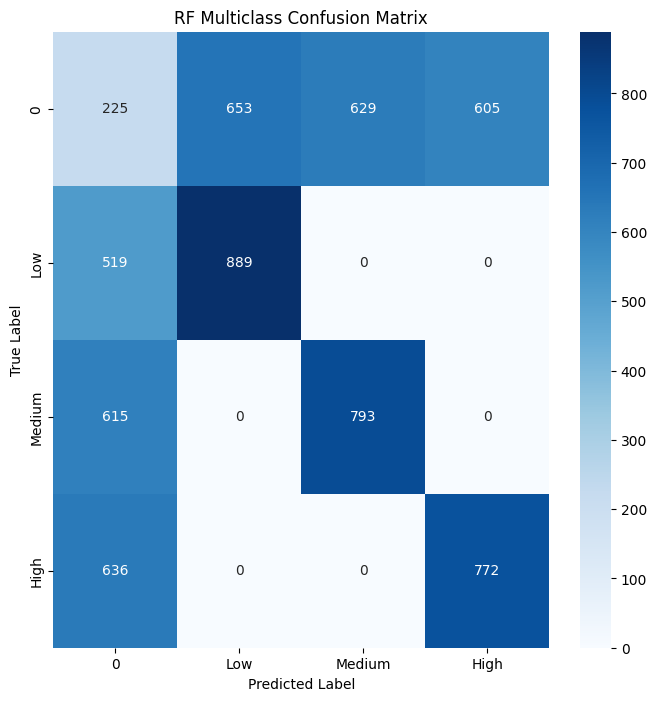

In [ ]:
# --- Random Forest ---
print("\n--- Random Forest ---")

# Binary Classification
start_time = time.time()

rf_binary = RandomForestClassifier(random_state=42)
rf_binary.fit(X_train_binary, y_train_binary)

train_time_binary_rf = time.time() - start_time
start_time = time.time()

y_pred_binary_rf = rf_binary.predict(X_test_binary)

predict_time_binary_rf = time.time() - start_time
print(f"Binary Training Time: {train_time_binary_rf:.2f} seconds")
print(f"Binary Prediction Time: {predict_time_binary_rf:.2f} seconds")

print("Binary Classification Accuracy:", accuracy_score(y_test_binary, y_pred_binary_rf))
print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary_rf))
plot_confusion_matrix(y_test_binary, y_pred_binary_rf, classes=['Just Listen', 'Memory'], title='RF Binary Confusion Matrix')

# Multiclass Classification

start_time = time.time()

rf_multi = RandomForestClassifier(random_state=42)
rf_multi.fit(X_train_multi, y_train_multi)

train_time_multi_rf = time.time() - start_time
start_time = time.time()

y_pred_multi_rf = rf_multi.predict(X_test_multi)

predict_time_multi_rf = time.time() - start_time
print(f"Multiclass Training Time: {train_time_multi_rf:.2f} seconds")
print(f"Multiclass Prediction Time: {predict_time_multi_rf:.2f} seconds")

print("Multiclass Classification Accuracy:", accuracy_score(y_test_multi, y_pred_multi_rf))
print("Multiclass Classification Report:\n", classification_report(y_test_multi, y_pred_multi_rf))
plot_confusion_matrix(y_test_multi, y_pred_multi_rf, classes=['0', 'Low', 'Medium', 'High'], title='RF Multiclass Confusion Matrix')


--- XGBoost ---
Binary Training Time: 576.90 seconds
Binary Prediction Time: 0.30 seconds
Binary Classification Accuracy: 0.6043244949494949
Binary Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2112
           1       0.64      0.91      0.75      4224

    accuracy                           0.60      6336
   macro avg       0.32      0.45      0.38      6336
weighted avg       0.43      0.60      0.50      6336



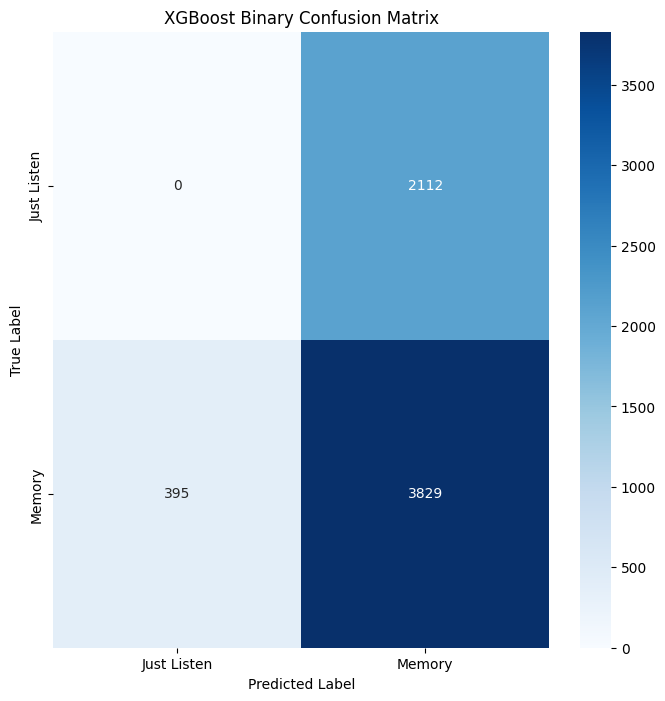

Multiclass Training Time: 2084.40 seconds
Multiclass Prediction Time: 0.47 seconds
Multiclass Classification Accuracy: 0.5284090909090909
Multiclass Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.11      0.13      2112
           1       0.63      0.80      0.71      1408
           2       0.62      0.74      0.68      1408
           3       0.61      0.68      0.65      1408

    accuracy                           0.53      6336
   macro avg       0.51      0.58      0.54      6336
weighted avg       0.47      0.53      0.49      6336



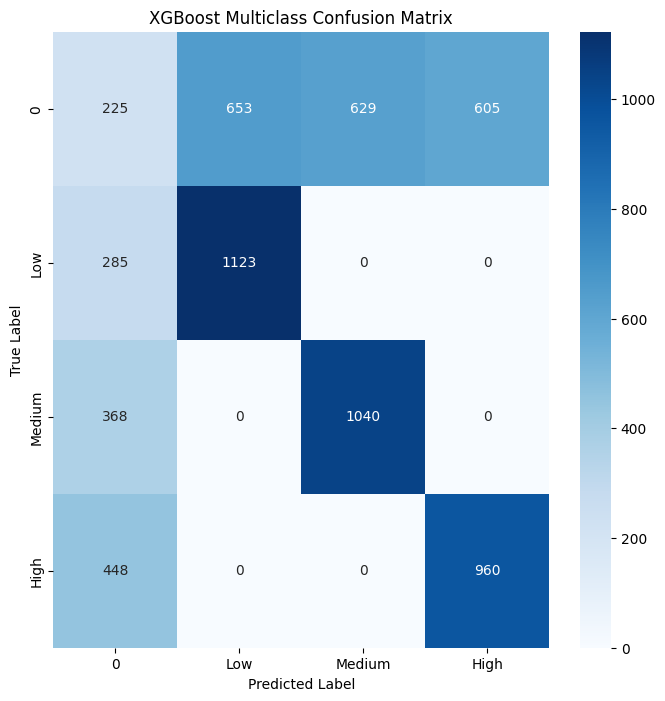

In [ ]:
# --- XGBoost ---
print("\n--- XGBoost ---")

# Binary Classification
start_time = time.time()

xgb_binary = xgb.XGBClassifier(random_state=42)
xgb_binary.fit(X_train_binary, y_train_binary)

train_time_binary_xgb = time.time() - start_time
start_time = time.time()

y_pred_binary_xgb = xgb_binary.predict(X_test_binary)

predict_time_binary_xgb = time.time() - start_time
print(f"Binary Training Time: {train_time_binary_xgb:.2f} seconds")
print(f"Binary Prediction Time: {predict_time_binary_xgb:.2f} seconds")

print("Binary Classification Accuracy:", accuracy_score(y_test_binary, y_pred_binary_xgb))
print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary_xgb))
plot_confusion_matrix(y_test_binary, y_pred_binary_xgb, classes=['Just Listen', 'Memory'], title='XGBoost Binary Confusion Matrix')


# Multiclass Classification
start_time = time.time()

xgb_multi = xgb.XGBClassifier(random_state=42)
xgb_multi.fit(X_train_multi, y_train_multi)

train_time_multi_xgb = time.time() - start_time
start_time = time.time()

y_pred_multi_xgb = xgb_multi.predict(X_test_multi)

predict_time_multi_xgb = time.time() - start_time
print(f"Multiclass Training Time: {train_time_multi_xgb:.2f} seconds")
print(f"Multiclass Prediction Time: {predict_time_multi_xgb:.2f} seconds")

print("Multiclass Classification Accuracy:", accuracy_score(y_test_multi, y_pred_multi_xgb))
print("Multiclass Classification Report:\n", classification_report(y_test_multi, y_pred_multi_xgb))
plot_confusion_matrix(y_test_multi, y_pred_multi_xgb, classes=['0', 'Low', 'Medium', 'High'], title='XGBoost Multiclass Confusion Matrix')

In [ ]:
#time_points = int(reshaped_data.shape[1] / n_features)  # Total features divided by features per time point
# Assuming 2 channels (eyes)
channels = 2
n_features = channels  # n_features should be equal to the number of channels (eyes) in this case

# Initialize n_features directly with the number of channels (2 in this case)
n_features = 2

# Calculate time_points correctly
time_points = int(reshaped_data.shape[1] / n_features)

# Now reshape with the correct dimensions
X_train_binary_cnn = X_train_binary.reshape(-1, time_points, n_features)
X_test_binary_cnn = X_test_binary.reshape(-1, time_points, n_features)
X_train_multi_cnn = X_train_multi.reshape(-1, time_points, n_features)
X_test_multi_cnn = X_test_multi.reshape(-1, time_points, n_features)

X_train_binary_lstm = X_train_binary.reshape(-1, time_points, n_features)
X_test_binary_lstm = X_test_binary.reshape(-1, time_points, n_features)
X_train_multi_lstm = X_train_multi.reshape(-1, time_points, n_features)
X_test_multi_lstm = X_test_multi.reshape(-1, time_points, n_features)


--- CNN ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Binary Training Time: 1894.86 seconds
Binary Prediction Time: 21.45 seconds
Binary Classification Accuracy: 0.3333333432674408
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step
Binary Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50      2112
           1       0.00      0.00      0.00      4224

    accuracy                           0.33      6336
   macro avg       0.17      0.50      0.25      6336
weighted avg       0.11      0.33      0.17      6336



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


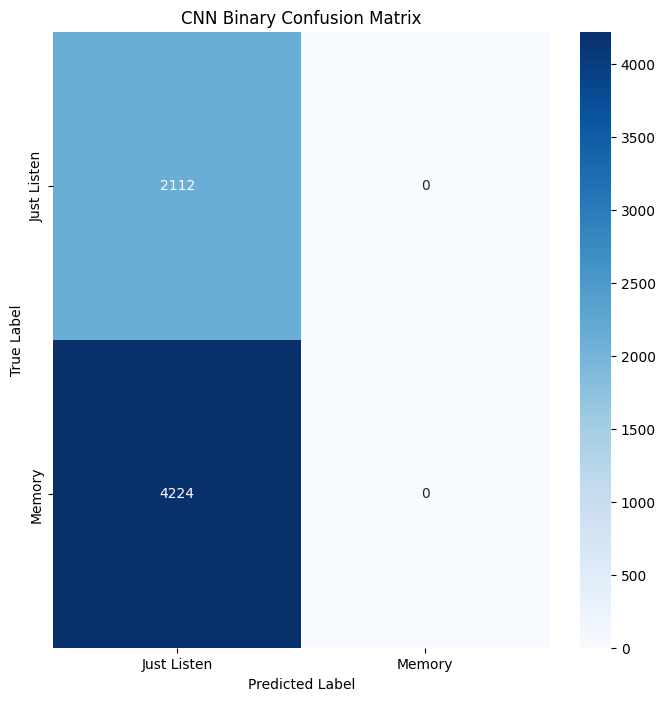

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Multiclass Training Time: 1916.92 seconds
Multiclass Prediction Time: 11.10 seconds
Multiclass Classification Accuracy: 0.3333333432674408
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Multiclass Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50      2112
           1       0.00      0.00      0.00      1408
           2       0.00      0.00      0.00      1408
           3       0.00      0.00      0.00      1408

    accuracy                           0.33      6336
   macro avg       0.08      0.25      0.12      6336
weighted avg       0.11      0.33      0.17      6336



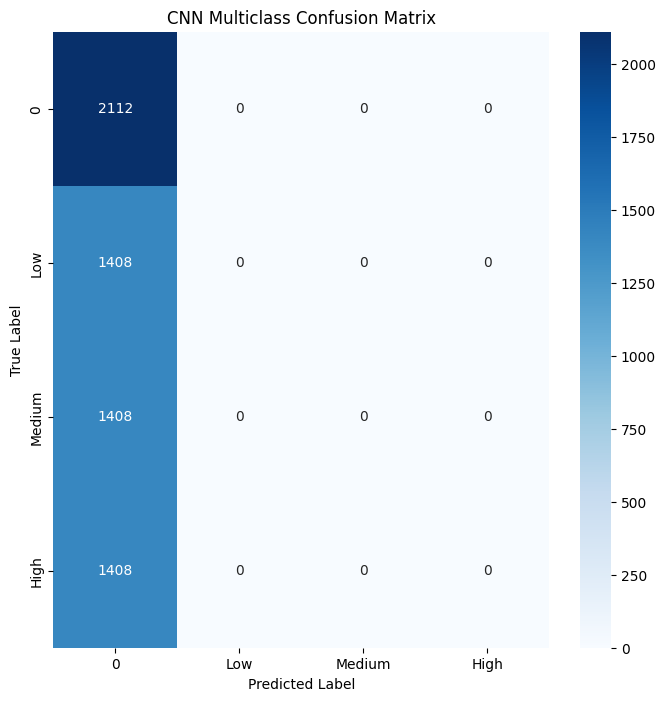

In [ ]:
# --- CNN ---
print("\n--- CNN ---")

# Binary Classification CNN

start_time = time.time()
model_cnn_binary = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_points, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])
model_cnn_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn_binary.fit(X_train_binary_cnn, y_train_binary, epochs=10, batch_size=32, verbose=0)

train_time_binary_cnn = time.time() - start_time
start_time = time.time()

_, accuracy_binary_cnn = model_cnn_binary.evaluate(X_test_binary_cnn, y_test_binary, verbose=0)

predict_time_binary_cnn = time.time() - start_time
print(f"Binary Training Time: {train_time_binary_cnn:.2f} seconds")
print(f"Binary Prediction Time: {predict_time_binary_cnn:.2f} seconds")

print("Binary Classification Accuracy:", accuracy_binary_cnn)

y_pred_binary_cnn_probs = model_cnn_binary.predict(X_test_binary_cnn)
y_pred_binary_cnn = (y_pred_binary_cnn_probs > 0.5).astype("int32")

print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary_cnn))
plot_confusion_matrix(y_test_binary, y_pred_binary_cnn, classes=['Just Listen', 'Memory'], title='CNN Binary Confusion Matrix')

# Multiclass Classification CNN

start_time = time.time()

model_cnn_multi = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_points, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4-class output
])
model_cnn_multi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn_multi.fit(X_train_multi_cnn, y_train_multi, epochs=10, batch_size=32, verbose=0)

train_time_multi_cnn = time.time() - start_time
start_time = time.time()

_, accuracy_multi_cnn = model_cnn_multi.evaluate(X_test_multi_cnn, y_test_multi, verbose=0)

predict_time_multi_cnn = time.time() - start_time
print(f"Multiclass Training Time: {train_time_multi_cnn:.2f} seconds")
print(f"Multiclass Prediction Time: {predict_time_multi_cnn:.2f} seconds")

print("Multiclass Classification Accuracy:", accuracy_multi_cnn)

y_pred_multi_cnn_probs = model_cnn_multi.predict(X_test_multi_cnn)
y_pred_multi_cnn = np.argmax(y_pred_multi_cnn_probs, axis=-1)

print("Multiclass Classification Report:\n", classification_report(y_test_multi, y_pred_multi_cnn))
plot_confusion_matrix(y_test_multi, y_pred_multi_cnn, classes=['0', 'Low', 'Medium', 'High'], title='CNN Multiclass Confusion Matrix')


--- LSTM ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Binary Training Time: 9045.00 seconds
Binary Prediction Time: 143.37 seconds
Binary Classification Accuracy: 0.3333333432674408
198/198 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Binary Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50      2112
           1       0.00      0.00      0.00      4224

    accuracy                           0.33      6336
   macro avg       0.17      0.50      0.25      6336
weighted avg       0.11      0.33      0.17      6336



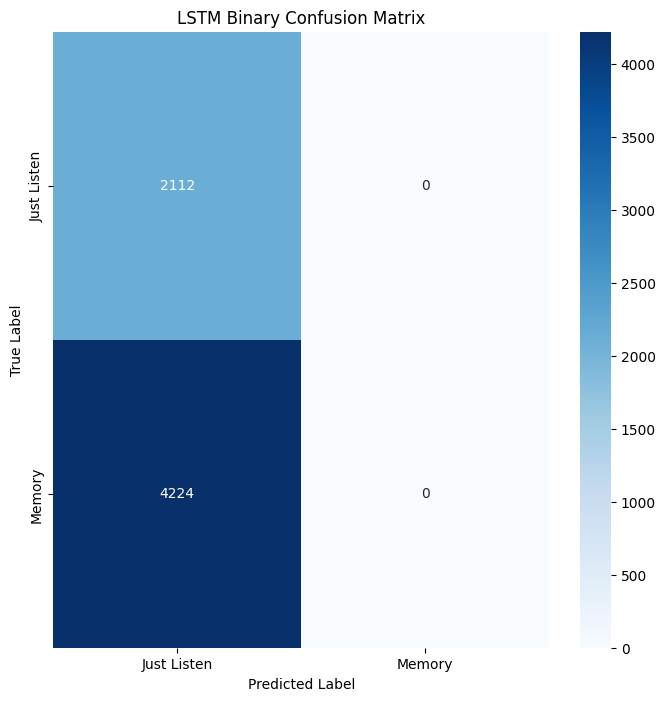

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Multiclass Training Time: 8750.77 seconds
Multiclass Prediction Time: 83.19 seconds
Multiclass Classification Accuracy: 0.3333333432674408
198/198 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step
Multiclass Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50      2112
           1       0.00      0.00      0.00      1408
           2       0.00      0.00      0.00      1408
           3       0.00      0.00      0.00      1408

    accuracy                           0.33      6336
   macro avg       0.08      0.25      0.12      6336
weighted avg       0.11      0.33      0.17      6336



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


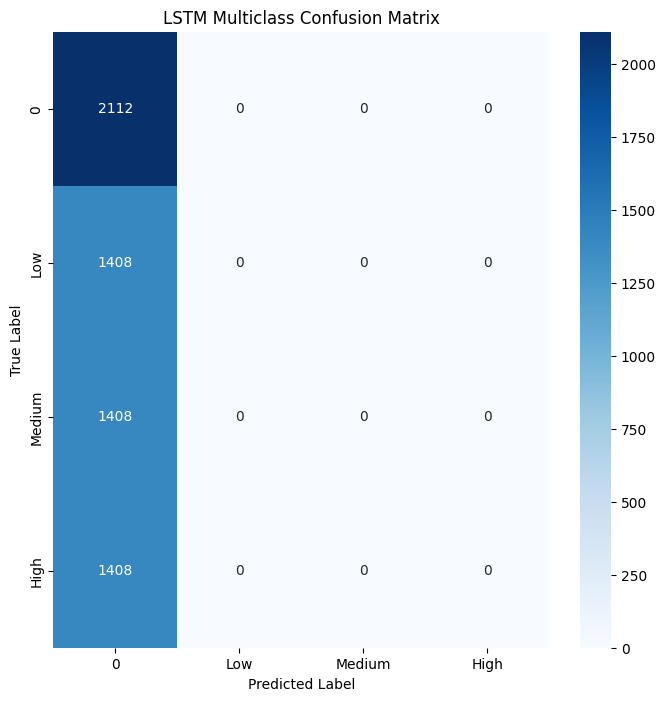

In [ ]:
# --- LSTM ---
print("\n--- LSTM ---")

# Binary Classification LSTM

start_time = time.time()

model_lstm_binary = Sequential([
    LSTM(64, activation='relu', input_shape=(time_points, n_features)),
    Dense(1, activation='sigmoid')
])
model_lstm_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_binary.fit(X_train_binary_lstm, y_train_binary, epochs=10, batch_size=32, verbose=0)

train_time_binary_lstm = time.time() - start_time
start_time = time.time()

_, accuracy_binary_lstm = model_lstm_binary.evaluate(X_test_binary_lstm, y_test_binary, verbose=0)

predict_time_binary_lstm = time.time() - start_time
print(f"Binary Training Time: {train_time_binary_lstm:.2f} seconds")
print(f"Binary Prediction Time: {predict_time_binary_lstm:.2f} seconds")

print("Binary Classification Accuracy:", accuracy_binary_lstm)

y_pred_binary_lstm_probs = model_lstm_binary.predict(X_test_binary_lstm)
y_pred_binary_lstm = (y_pred_binary_lstm_probs > 0.5).astype("int32")

print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary_lstm))
plot_confusion_matrix(y_test_binary, y_pred_binary_lstm, classes=['Just Listen', 'Memory'], title='LSTM Binary Confusion Matrix')

# Multiclass Classification LSTM

start_time = time.time()

model_lstm_multi = Sequential([
    LSTM(64, activation='relu', input_shape=(time_points, n_features)),
    Dense(4, activation='softmax')
])
model_lstm_multi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm_multi.fit(X_train_multi_lstm, y_train_multi, epochs=10, batch_size=32, verbose=0)

train_time_multi_lstm = time.time() - start_time
start_time = time.time()

_, accuracy_multi_lstm = model_lstm_multi.evaluate(X_test_multi_lstm, y_test_multi, verbose=0)

predict_time_multi_lstm = time.time() - start_time
print(f"Multiclass Training Time: {train_time_multi_lstm:.2f} seconds")
print(f"Multiclass Prediction Time: {predict_time_multi_lstm:.2f} seconds")

print("Multiclass Classification Accuracy:", accuracy_multi_lstm)

y_pred_multi_lstm_probs = model_lstm_multi.predict(X_test_multi_lstm)
y_pred_multi_lstm = np.argmax(y_pred_multi_lstm_probs, axis=-1)

print("Multiclass Classification Report:\n", classification_report(y_test_multi, y_pred_multi_lstm))
plot_confusion_matrix(y_test_multi, y_pred_multi_lstm, classes=['0', 'Low', 'Medium', 'High'], title='LSTM Multiclass Confusion Matrix')

In [ ]:
# --- Transformer ---

import tensorflow as tf # Importing tensorflow as tf
print("\n--- Transformer ---")

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Assuming 2 channels (eyes)
channels = 2
n_features = channels  # n_features should be equal to the number of channels (eyes) in this case

# Initialize n_features directly with the number of channels (2 in this case)
n_features = 2

# Assuming 'reshaped_data' is defined and accessible in this scope
# Calculate time_points correctly
time_points = int(reshaped_data.shape[1] / n_features) # defining time_points here


# Binary Classification Transformer
n_features= 2
embed_dim = n_features  # Embedding size
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network

inputs_binary_transformer = tf.keras.layers.Input(shape=(time_points, embed_dim))
x_binary_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(inputs_binary_transformer, training=True)
x_binary_transformer = Flatten()(x_binary_transformer)
x_binary_transformer = Dense(64, activation="relu")(x_binary_transformer)
outputs_binary_transformer = Dense(1, activation="sigmoid")(x_binary_transformer)

model_transformer_binary = tf.keras.Model(inputs=inputs_binary_transformer, outputs=outputs_binary_transformer)
model_transformer_binary.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

start_time = time.time()

model_transformer_binary.fit(X_train_binary_lstm, y_train_binary, epochs=10, batch_size=32, verbose=0)

train_time_binary_transformer = time.time() - start_time
start_time = time.time()

_, accuracy_binary_transformer = model_transformer_binary.evaluate(X_test_binary_lstm, y_test_binary, verbose=0)

predict_time_binary_transformer = time.time() - start_time
print(f"Binary Transformer Training Time: {train_time_binary_transformer:.2f} seconds")
print(f"Binary Transformer Prediction Time: {predict_time_binary_transformer:.2f} seconds")

print("Binary Classification Accuracy:", accuracy_binary_transformer)

y_pred_binary_transformer_probs = model_transformer_binary.predict(X_test_binary_lstm) # Changed to X_test_binary_lstm
y_pred_binary_transformer = (y_pred_binary_transformer_probs > 0.5).astype("int32")

print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary_transformer))
plot_confusion_matrix(y_test_binary, y_pred_binary_transformer, classes=['Just Listen', 'Memory'], title='Transformer Binary Confusion Matrix')

# Multiclass Classification Transformer
inputs_multi_transformer = tf.keras.layers.Input(shape=(time_points, embed_dim))
x_multi_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(inputs_multi_transformer, training=True)
x_multi_transformer = Flatten()(x_multi_transformer)
x_multi_transformer = Dense(64, activation="relu")(x_multi_transformer)
outputs_multi_transformer = Dense(4, activation="softmax")(x_multi_transformer)

model_transformer_multi = tf.keras.Model(inputs=inputs_multi_transformer, outputs=outputs_multi_transformer)
model_transformer_multi.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

start_time = time.time()

model_transformer_multi.fit(X_train_multi_lstm, y_train_multi, epochs=10, batch_size=32, verbose=0)

train_time_multi_transformer = time.time() - start_time
start_time = time.time()

_, accuracy_multi_transformer = model_transformer_multi.evaluate(X_test_multi_lstm, y_test_multi, verbose=0)

predict_time_multi_transformer = time.time() - start_time
print(f"Multiclass Transformer Training Time: {train_time_multi_transformer:.2f} seconds")
print(f"Multiclass Transformer Prediction Time: {predict_time_multi_transformer:.2f} seconds")

print("Multiclass Classification Accuracy:", accuracy_multi_transformer)

y_pred_multi_transformer_probs = model_transformer_multi.predict(X_test_multi_lstm) # Changed to X_test_multi_lstm
y_pred_multi_transformer = np.argmax(y_pred_multi_transformer_probs, axis=-1)

print("Multiclass Classification Report:\n", classification_report(y_test_multi, y_pred_multi_transformer))
plot_confusion_matrix(y_test_multi, y_pred_multi_transformer, classes=['0', 'Low', 'Medium', 'High'], title='Transformer Multiclass Confusion Matrix')


--- Transformer ---
